# Facebook + Twitter Multiclass Classification in Keras
    Uses Keras word embedding + LSTM for classification

# Instructions to run this Notebook

This Notebook was created in a Python 3.6 environment.

All the libraries are installed with pip. When the code fails to run, just google how to install the missing library. 

The only special case is the spacy library. You need to run the command window as Administrator and then run pip. 
If you still get this error:
OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.
You need to run this as Adminnistrator
 python -m spacy link en_core_web_sm en

Code in this Norebook is based on this tutorial:
https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

# Parameters to run this Notebook

In [1]:
input_file_name = "Step6_Create_Datasets_for_Python.xlsx"
input_sheet_name = "Labelled_Data"

unlabelled_file_name = "Step6_Create_Datasets_for_Python.xlsx"
unlabelled_sheet_name = "Unlabelled_data"


Fix error in 
nlp = spacy.load('en')
OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.


Run as Administrator: python -m spacy link en_core_web_sm en
    

In [2]:
import base64
import numpy as np
import pandas as pd
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 100000) # Extend the display width to prevent split functions to not cover full text

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Plotly imports
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
#import plotly.graph_objs as go
#import plotly.tools as tls

# Other imports
#from collections import Counter
######from scipy.misc import imread  deprecated. Import imread from imageio instead

from imageio import imread

#from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.style as style 
%matplotlib inline


# Libraries for gensim and spacy
#import json
#import glob
#from tqdm.notebook import tqdm
#from textblob import TextBlob

#import spacy # Leading library for NLP
#nlp = spacy.load('en')

import re
import string

#import gensim
#from gensim import matutils, models
#import scipy.sparse

#from gensim.utils import simple_preprocess
#from gensim.parsing.preprocessing import STOPWORDS

from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk

#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator



# 1. Load and Inspect the Dataset

In [3]:
# Loading in the Labelled Social Media Postsdata with Pandas

dfInput = pd.read_excel(input_file_name, sheet_name=input_sheet_name)

In [4]:
dfInput.head(5)

,Source,Date,Post_id,Sentence_id,LDA_Dominant_Topic,LABEL_ID,LABEL1,LABEL2,Search_SHN,Search_Precautions,Search_Crowds,Text,Dominant_Pct,Dominant_Topic_Keywords
0,1,2020-02-01,0,1,1,1,OTHER,RUMOUR,NaN,NaN,NaN,update on the 2019 novel coronavirus (ncov) - ...,0.083333,case| resident| end| friend| practitioner| lab...
1,1,2020-02-01,0,2,11,1,OTHER,RUMOUR,NaN,NaN,NaN,there is no need to avoid places where persons...,0.091954,day| place| patient| worker| shn| number| trav...
2,1,2020-02-01,0,3,8,2,IMPORT_VS_LOCAL,NaN,NaN,NaN,NaN,there is also currently no evidence of communi...,0.094650,measure| transmission| risk| health| virus| si...
3,1,2020-02-01,1,2,1,2,IMPORT_VS_LOCAL,NaN,NaN,NaN,NaN,16 confirmed cases were earlier announced by m...,0.079060,case| resident| end| friend| practitioner| lab...
4,1,2020-02-01,1,3,8,2,IMPORT_VS_LOCAL,NaN,NaN,NaN,NaN,there is currently no evidence of community sp...,0.094949,measure| transmission| risk| health| virus| si...


In [5]:
dfInput.LABEL_ID.value_counts()

7     117
11    116
4     110
1      86
15     74
9      74
6      65
3      63
2      40
16     34
5      29
10     25
8      21
13     20
12     19
14     14
Name: LABEL_ID, dtype: int64

In [6]:
# There's a null somewhere in the LABEL_ID
nan_rows = dfInput[dfInput['LABEL_ID'].isnull()]
nan_rows

,Source,Date,Post_id,Sentence_id,LDA_Dominant_Topic,LABEL_ID,LABEL1,LABEL2,Search_SHN,Search_Precautions,Search_Crowds,Text,Dominant_Pct,Dominant_Topic_Keywords


# Clean Text

In [7]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['covid', 'covid-19', 'read', 'link', 'http', 'https'])
stop_words.extend(['covid', 'covid-19', 'https', 'http'])

In [ ]:
#dfInput.Text = dfInput.Text.astype(str)


In [8]:
dfInput = dfInput.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    #text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

#dfInput['Text'] = dfInput['Text'].apply(clean_text)
#dfInput['Text'] = dfInput['Text'].str.replace('\d+', '')

In [10]:
dfInput.Text = dfInput.Text.astype(str)
dfInput['Text'] = dfInput['Text'].apply(clean_text)
dfInput['Text'] = dfInput['Text'].str.replace('\d+', '')


In [11]:
dfInput.head()

,Source,Date,Post_id,Sentence_id,LDA_Dominant_Topic,LABEL_ID,LABEL1,LABEL2,Search_SHN,Search_Precautions,Search_Crowds,Text,Dominant_Pct,Dominant_Topic_Keywords
0,1,2020-02-01,0,1,1,1,OTHER,RUMOUR,NaN,NaN,NaN,update novel coronavirus ncov false rumours w...,0.083333,case| resident| end| friend| practitioner| lab...
1,1,2020-02-01,0,2,11,1,OTHER,RUMOUR,NaN,NaN,NaN,need avoid places persons suspected confirmed ...,0.091954,day| place| patient| worker| shn| number| trav...
2,1,2020-02-01,0,3,8,2,IMPORT_VS_LOCAL,NaN,NaN,NaN,NaN,also currently evidence community spreadfor in...,0.094650,measure| transmission| risk| health| virus| si...
3,1,2020-02-01,1,2,1,2,IMPORT_VS_LOCAL,NaN,NaN,NaN,NaN,confirmed cases earlier announced mohboth cas...,0.079060,case| resident| end| friend| practitioner| lab...
4,1,2020-02-01,1,3,8,2,IMPORT_VS_LOCAL,NaN,NaN,NaN,NaN,currently evidence community spread singaporet...,0.094949,measure| transmission| risk| health| virus| si...


# LSTM Modeling
Vectorize consumer complaints text, by turning each text into either a sequence of integers or into a vector.
Limit the data set to the top 5,0000 words.
Set the max number of words in each complaint at 250.

In [12]:
# Import Keras library
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector,SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from keras.callbacks import EarlyStopping



In [13]:
# The maximum number of words to be used. (most frequent)from keras.models import Sequential
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(dfInput['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 1892 unique tokens.


# Split dataset into training and testing

In [ ]:
# Original tutorial code. Replaced with Startified Shuffle Split so all text categories are represented

# Split dataset into training and testing
#from sklearn.model_selection import train_test_split

#X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
#print(X_train.shape,Y_train.shape)
#print(X_test.shape,Y_test.shape)



In [14]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(dfInput, dfInput["LABEL_ID"]):
    strat_train_set = dfInput.iloc[train_index] #replaced loc with iloc to fix error!
    strat_test_set = dfInput.iloc[test_index]

In [15]:
print (strat_train_set.shape)
print (strat_test_set.shape)

(725, 14)
(182, 14)


# Truncate and pad the input sequences so that they are all in the same length for modeling.

In [22]:
X = tokenizer.texts_to_sequences(dfInput['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
#print('Shape of data tensor:', X.shape)

In [16]:
X_train = tokenizer.texts_to_sequences(strat_train_set['Text'].values)
X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor training set:', X_train.shape)

X_test = tokenizer.texts_to_sequences(strat_test_set['Text'].values)
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor training set:', X_test.shape)

Shape of data tensor training set: (725, 250)
Shape of data tensor training set: (182, 250)


Get the labels. Use the numeric version LABEL_ID, not the string LABEL1
"get_dummies" produces One Hot encoding for the categories

In [17]:
Y_train = pd.get_dummies(strat_train_set['LABEL_ID']).values
print('Shape of label tensor training set:', Y_train.shape)

Y_test = pd.get_dummies(strat_test_set['LABEL_ID']).values
print('Shape of label tensor test set:', Y_test.shape)


Shape of label tensor training set: (725, 16)
Shape of label tensor test set: (182, 16)


In [ ]:
# Check what "get_dummies" looks like
pd.get_dummies(strat_train_set['LABEL_ID'])

In [ ]:
strat_train_set.iloc[241]

This doesn't look right. LABEL_ID = 7 becomes 1 in encoding. How do you know it's how to put the labels back?
Try using it with string category

In [ ]:
# This looks wrong too. Now location 241 shows "OTHER". Correct should be "TESTING"
pd.get_dummies(strat_train_set['LABEL1'])

Let's use the string categories and see if the predictions make any sense.

In [18]:
Y_train = pd.get_dummies(strat_train_set['LABEL1']).values
print('Shape of label tensor training set:', Y_train.shape)

Y_test = pd.get_dummies(strat_test_set['LABEL1']).values
print('Shape of label tensor test set:', Y_test.shape)

Shape of label tensor training set: (725, 16)
Shape of label tensor test set: (182, 16)


# Ready to create the Model! 

--> Notes from original tutorial 
The first layer is the embedded layer that uses 100 length vectors to represent each word.
SpatialDropout1D performs variational dropout in NLP models.
The next layer is the LSTM layer with 100 memory units.
The output layer must create 16 output values, one for each class.
Activation function is softmax for multi-class classification.
Because it is a multi-class classification problem, categorical_crossentropy is used as the loss function.


###In this version, we are using the Keras Embedding model. Later we might try Glove

# What is "Variational Dropout"?

Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.
https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

####It is basically a technique to prevent the network to overfit the training data and make better generalizations.




# Why use EsrlyStopping Callback?

A problem with training neural networks is in the choice of the number of training epochs to use.

Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [23]:
from keras.models import Sequential

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set epochs = arbitrary high number. The EarlyStopping callback will exit when accuracy stops improving
epochs = 20
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/20
11/11 [==============================] - 6s 559ms/step - loss: 2.7411 - accuracy: 0.2393 - val_loss: 2.6914 - val_accuracy: 0.3151
Epoch 2/20
11/11 [==============================] - 6s 546ms/step - loss: 2.5442 - accuracy: 0.2485 - val_loss: 2.5429 - val_accuracy: 0.2740
Epoch 3/20
11/11 [==============================] - 6s 562ms/step - loss: 2.3409 - accuracy: 0.2791 - val_loss: 2.3877 - val_accuracy: 0.3014
Epoch 4/20
11/11 [==============================] - 6s 568ms/step - loss: 2.0841 - accuracy: 0.3589 - val_loss: 2.1524 - val_accuracy: 0.3425
Epoch 5/20
11/11 [==============================] - 6s 584ms/step - loss: 1.8096 - accuracy: 0.4187 - val_loss: 1.9115 - val_accuracy: 0.3973
Epoch 6/20
11/11 [==============================] - 6s 575ms/step - loss: 1.5449 - accuracy: 0.5613 - val_loss: 1.6551 - val_accuracy: 0.5616
Epoch 7/20
11/11 [==============================] - 6s 570ms/step - loss: 1.3035 - accuracy: 0.6472 - val_loss: 1.5011 - val_accuracy: 0.5890
Epoch 

In [24]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6/6 [==============================] - 0s 39ms/step - loss: 0.7028 - accuracy: 0.7692
Test set
  Loss: 0.703
  Accuracy: 0.769


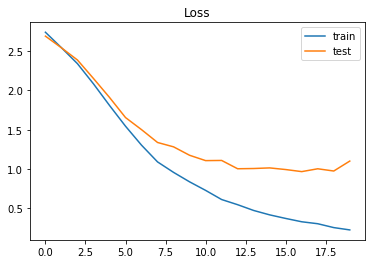

In [25]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
def Predict_Post_OLD(text):
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    labels = ['BORDER_CONTROLS','CIRCUIT','CONDITION','CRITICAL','DORMS_OUTBREAKS','IMPORT_VS_LOCAL','LIFT_RESTRICTIONS','NEW_CASES','OTHER','PRECAUTIONS','RECOVERY','RESPONSIBILITY','SAFE_DISTANCING','SHN','TESTING','TRACING']
    #print(pred, labels[np.argmax(pred)])
    return labels[np.argmax(pred)]

In [49]:
def Predict_Post(in_text):
    text = [in_text]
    seq = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    labels = ['BORDER_CONTROLS','CIRCUIT','CONDITION','CRITICAL','DORMS_OUTBREAKS','IMPORT_VS_LOCAL','LIFT_RESTRICTIONS','NEW_CASES','OTHER','PRECAUTIONS','RECOVERY','RESPONSIBILITY','SAFE_DISTANCING','SHN','TESTING','TRACING']
    pred_index = np.argmax(pred)
    prediction = "NOT_FOUND"
    #print (pred_index)
    if pred_index < len(labels): prediction = labels[np.argmax(pred)]
    #print ('max pred: ', np.argmax(pred))
    
    return prediction

In [41]:
new_post = 'in all 29 have fully recovered from the infection and have been discharged from hospital.'
print (Predict_Post(new_post))


10
RECOVERY


In [42]:
new_post = 'of the 73 confirmed cases who are still in hospital most are stable or improving.'
print (Predict_Post(new_post))

2
CONDITION


In [43]:
new_post = 'as of 12 may 2020 12pm we have confirmed and verified an additional 884 cases of covid-19 infection in singapore.'
print (Predict_Post(new_post))

7
NEW_CASES


In [44]:
new_post = 'breakdown: 4 imported 5 cases in the community & 472 cases residing in dorms.'
print (Predict_Post(new_post))

4
DORMS_OUTBREAKS


In [45]:
# first row in Unlabelled Dataset
new_post = 'as of 2 february 2020 2pm we have not been notified of any new confirmed cases of 2019 novel coronavirus infection in singapore.'
print (Predict_Post(new_post))


5
IMPORT_VS_LOCAL


# Looks good enough to save this model! 

# Load Unlabelled Dataset and classify the posts

In [32]:
# Loading in the Unlabelled dataset

dfUnlabelled = pd.read_excel(unlabelled_file_name, sheet_name=unlabelled_sheet_name)

In [33]:
dfUnlabelled.Text = dfUnlabelled.Text.astype(str)
#dfUnlabelled['CleanText'] = dfUnlabelled['Text'].apply(clean_text)
#dfUnlabelled['CleanText'] = dfUnlabelled['CleanText'].str.replace('\d+', '')


In [34]:
dfUnlabelled.head(5)

,Source,Date,Post_id,Sentence_id,LDA_Dominant_Topic,LABEL1,LABEL2,Search_SHN,Search_Precautions,Search_Crowds,Text,Dominant_Pct,Dominant_Topic_Keywords
0,1,2020-02-02,2,1,13,NaN,NaN,NaN,NaN,NaN,as of 2 february 2020 2pm we have not been not...,0.074786,case| infection| d_of| mission| morning| thoug...
1,1,2020-02-03,3,1,8,NaN,NaN,NaN,NaN,NaN,minister for health gan kim yong delivered a m...,0.224966,measure| transmission| risk| health| virus| si...
2,1,2020-02-03,4,1,9,NaN,NaN,NaN,NaN,NaN,as of 3 february 2020 2pm we have not been not...,0.074786,infection| case| spread| video| consultation| ...
3,1,2020-02-03,4,2,15,NaN,NaN,NaN,NaN,NaN,eighteen confirmed imported cases were earlier...,0.120219,detail| release| press| news| www| investigati...
4,1,2020-02-04,5,6,15,NaN,NaN,NaN,NaN,NaN,he has recovered and has been comprehensively ...,0.139360,detail| release| press| news| www| investigati...


# Create predictions

In [46]:
dfUnlabelled.loc[0].Text

'as of 2 february 2020 2pm we have not been notified of any new confirmed cases of 2019 novel coronavirus infection in singapore.'

In [47]:
new_post = dfUnlabelled.loc[0].Text
print (Predict_Post(new_post))

5
IMPORT_VS_LOCAL


In [48]:
dfUnlabelled['Predicted_label'] = dfUnlabelled['Text'].apply(Predict_Post)

5
13
5
5
8
5
5
8
8
1
1
8
5
15
3
8
5
15
10
10
15
10
10
15
15
5
8
10
3
5
2
3
10
10
15
15
3
10
10
15
10
10
10
3
5
0
10
15
6
10
10
5
2
8
8
10
10
8
8
10
10
10
10
10
10
3
10
15
3
1
5
15
2
3
10
15
2
3
10
15
3
10
5
5
3
14
2
1
14
8
8
10
10
7
15
2
10
10
15
10
10
15
3
8
10
10
11
15
3
3
5
6
10
5
15
3
8
5
8
10
3
10
4
3
10
4
9
8
10
5
8
3
14
3
4
3
8
3
9
5
11
10
5
3
8
3
10
3
13
5
3
8
6
8
6
8
8
4
5
2
3
8
15
10
2
13
6
0
10
10
7
2
3
8
10
15
8
1
1
8
11
8
10
10
15
15
3
11
10
10
4
15
15
7
4
4
4
10
2
8
7
10
3
10
2
8
7
4
3
7
10
3
8
1
8
7
10
10
5
10
5
10
2
7
10
2
1
8
1
8
6
6
1
4
5
4
2
4
5
4
5
7
4
10
2
7
4
10
4
5
10
1
6
15
1
8
8
8
1
8
1
8
8
8
8
1
0
5
8
8
7
4
10
1
1
7
4
4
5
7
4
10
4
8
8
8
10
5
5
7
4
5
7
4
10
4
5
8
7
8
8
9
8
11
1
8
9
8
8
8
11
4
10
1
7
4
10
4
5
7
4
10
4
1
10
10
10
8
8
8
8
8
8
1
8
7
4
10
4
5
8
10
10
5
7
4
4
5
5
6
8
6
8
7
4
10
8
8
8
8
8
11
9
1
1
6
8
8
4
5
7
4
10
10
2
4
5
7
4
10
2
8
5
8
11
8
6
6
8
4
5
1
5
7
4
10
2
4
6
1
11
1
8
8
8
11
8
9
7
4
2
6
5
8
9
8
6
6
8
8
4
5
7
4
2
4
5
4
10
2
4
5
5
8
1
8
8
11
6

Once Model is Selected, add topics to dataframe and save as CSV

In [50]:
dfUnlabelled.head(5)

,Source,Date,Post_id,Sentence_id,LDA_Dominant_Topic,LABEL1,LABEL2,Search_SHN,Search_Precautions,Search_Crowds,Text,Dominant_Pct,Dominant_Topic_Keywords,Predicted_label
0,1,2020-02-02,2,1,13,NaN,NaN,NaN,NaN,NaN,as of 2 february 2020 2pm we have not been not...,0.074786,case| infection| d_of| mission| morning| thoug...,IMPORT_VS_LOCAL
1,1,2020-02-03,3,1,8,NaN,NaN,NaN,NaN,NaN,minister for health gan kim yong delivered a m...,0.224966,measure| transmission| risk| health| virus| si...,SHN
2,1,2020-02-03,4,1,9,NaN,NaN,NaN,NaN,NaN,as of 3 february 2020 2pm we have not been not...,0.074786,infection| case| spread| video| consultation| ...,IMPORT_VS_LOCAL
3,1,2020-02-03,4,2,15,NaN,NaN,NaN,NaN,NaN,eighteen confirmed imported cases were earlier...,0.120219,detail| release| press| news| www| investigati...,IMPORT_VS_LOCAL
4,1,2020-02-04,5,6,15,NaN,NaN,NaN,NaN,NaN,he has recovered and has been comprehensively ...,0.139360,detail| release| press| news| www| investigati...,OTHER


# Save the classified dataframe to CSV

In [52]:
#output_file_name = "Twitter_with_topics.csv"
output_file_name = "Combined_sentences_multiclass_lstm.csv"

dfUnlabelled.to_csv(output_file_name)